In [2]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics

using Flight.FlightComponents.Aircraft

using Flight.FlightAircraft.C172R

using ControlSystems

In [3]:
ac = Cessna172Rv0(NED()) |> System #linearization requires NED kinematics
ac.u.airframe.pld.m_pilot = 75
ac.u.airframe.pld.m_copilot = 75
ac.u.airframe.pld.m_lpass = 0
ac.u.airframe.pld.m_rpass = 0
ac.u.airframe.pld.m_baggage = 0

trim_params = C172Rv0.TrimParameters(
    loc = LatLon(),
    h = HOrth(1000),
    ψ_nb = 0.0,
    TAS = 40.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel = 1,
    mixture = 0.5,
    flaps = 0.0)

lm = Aircraft.linearize!(ac; trim_params)

Flight.FlightComponents.Control.LinearStateSpace{16, 4, 17, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(throttle = 1, aileron = 2, elevator = 3, rudder = 4)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, TAS = 10, α = 11, β = 12, f_x = 13, f_y = 14, f_z = 15, ω_eng = 16, m_fuel = 17)}}}, ComponentArrays.ComponentMatrix{Float64, Matrix{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}, ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 

### Longitudinal Dynamics

In [4]:
long_dyn = filter(lm;
    u = (:elevator, :throttle),
    x = (:v_x, :v_z, :θ, :q, :α_filt, :ω_eng),
    y = (:q, :θ, :α, :TAS, :f_x, :f_z, :ω_eng))

long_dyn_ss = long_dyn |> ss
long_dyn_tf = long_dyn_ss |> tf

#we can reduce the model further for CAS by omitting omega_eng and throttle
pitch_dyn = filter(lm; u = (:elevator,),
    x = (:v_x, :v_z, :θ, :q, :α_filt),
    y = (:q, :θ, :α, :TAS))

pitch_dyn_ss = pitch_dyn |> ss
pitch_dyn_tf = pitch_dyn_ss |> tf


TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
   9.268525469580453s^4 + 476.16545967170316s^3 + 787.2081881410722s^2 + 62.440083108999914s + 0.0011435227326046515
------------------------------------------------------------------------------------------------------------------------
1.0s^5 + 57.375720017963076s^4 + 488.22213038753125s^3 + 2444.1479237669773s^2 + 239.9881791819545s + 218.03282902241477

Input 1 to output 2
    7.105427357601002e-15s^4 + 9.268509111804462s^3 + 476.1646189875114s^2 + 787.2067624824111s + 62.43907996918722
------------------------------------------------------------------------------------------------------------------------
1.0s^5 + 57.375720017963076s^4 + 488.22213038753125s^3 + 2444.1479237669773s^2 + 239.9881791819545s + 218.03282902241477

Input 1 to output 3
    0.10240291048353356s^4 + 14.513649241133919s^3 + 470.6154709761172s^2 + 48.086748058176426s + 53.62458237629528
----------------------------------

In [5]:
#extract the elevator to q transfer function
e2q = long_dyn_tf[1,1]
@show zpk(e2q)

#the open loop TF is type 0, but with a zero almost at the origin, so in
#practice it has nearly derivative action. we can see that the steady state
#error for a step input is nearly 1, that is, the output falls back almost to
#zero
err_e2q = 1/(1+e2q)
@show zpk(err_e2q)
@show err_e2q(0)

#therefore, although adding a pure integrator will in theory yield a type 1
#system (and zero steady state error for step inputs), in practice (for
#reasonable time windows) it will still behave as a type 0. so, in addition to
#this integrator we can expect to require some more integral action in the
#feedforward path for satisfactory response.


zpk(e2q) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                         (1.0s + 49.667130350638345)(1.0s + 9.582552275632265)(1.0s + 1.6236140469521891)(1.0s + 0.04911473110377312)(1.0s + 3.103852612219659e-5)
9.26852546958041-----------------------------------------------------------------------------------------------------------------------------------------------------------
                (1.0s + 48.315816004398656)(1.0s + 9.582017994069524)(1.0s^2 + 8.977671994276683s + 49.64423564551947)(1.0s^2 + 0.04819984770640777s + 0.09426977979506836)

Continuous-time transfer function model


zpk(err_e2q) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
    (1.0s + 48.315816004398656)(1.0s + 9.582017994069524)(1.0s^2 + 8.977671994276683s + 49.64423564551947)(1.0s^2 + 0.04819984770640777s + 0.09426977979506836)
1.0--------------------------------------------------------------------------------------------------------------------------------------------------------------
   (1.0s + 47.92589020347124)(1.0s + 13.91174626481832)(1.0s + 9.583975792043713)(1.0s + 4.729674187331327)(1.0s^2 + 0.040944862367181145s + 0.07169040622241926)

Continuous-time transfer function model


err_e2q(0) = [0.9999949607400288;;]


1×1 Matrix{Float64}:
 0.9999949607400288

zpk(e2q_c) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                 (1.0s + 49.66713035063846)(1.0s^2 + 7.187499999999988s + 43.75000000000006)(1.0s + 1.6236140469521905)(1.0s + 0.049114731103773034)
148.29640751328657------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 48.31581600439878)(1.0s + 19.999999999999964)(1.0s^2 + 8.977671994276681s + 49.64423564551961)(1.0s^2 + 0.048199847706407735s + 0.09426977979506851)(1.0s)

Continuous-time transfer function model
ss_err_step = e2q_c_err(0) = [0.0;;]
ss_err_ramp = (tf(1, [1, 0]) * e2q_c_err)(0) = [Inf;;]


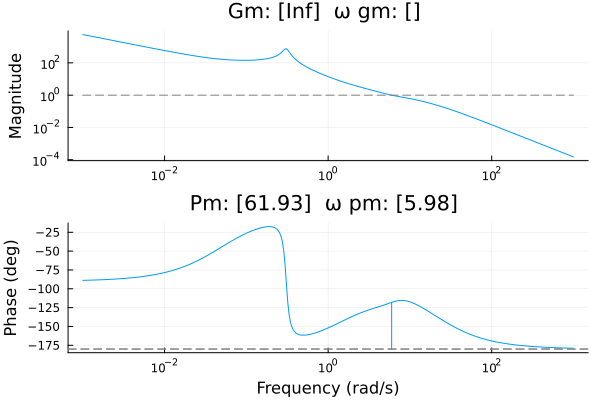

In [6]:
#we can start by trying a PID in series with the pure integrator previously
#indicated. rather than aiming for minimum steady state error (since the outward
#θ loop doesn't really care for that), we want reasonable stability margins

# k_p = 10
# k_i = 20
# k_d = 0.5
k_p = 4
k_i = 35
k_d = 0.6
q_comp = series(k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [0.05, 1]), tf(1, [1, 0]))
    
e2q_c = series(q_comp, e2q)
e2q_c = minreal(e2q_c, 1e-3)
@show zpk(e2q_c)

#error transfer function (setpoint - plant output)
e2q_c_err = 1/(1+e2q_c)
#the steady state error for a given test input is the final value of the ETF for
#that input. applying the final value theorem, the final value for a step input
#is found simply by settng s=0. therefore:
@show ss_err_step = e2q_c_err(0)

#and for a ramp input:
@show ss_err_ramp = (tf(1, [1, 0]) * e2q_c_err)(0)

marginplot(e2q_c)


zpk(cl) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                          (1.0s + 49.66713035063846)(1.0s^2 + 7.187499999999988s + 43.75000000000006)(1.0s + 1.6236140469521905)(1.0s + 0.049114731103773034)
148.29640751328657------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 48.44783104000699)(1.0s^2 + 20.506761865095765s + 166.51380596363515)(1.0s^2 + 6.072680515806562s + 28.87809785928952)(1.0s + 2.265732182100885)(1.0s + 0.04868224337159664)

Continuous-time transfer function model


poles(cl) = ComplexF64[-48.44783104000699 + 0.0im, -10.253380932547882 + 7.834665622456307im, -10.253380932547882 - 7.834665622456307im, -3.036340257903281 + 4.433817282830378im, -3.036340257903281 - 4.433817282830378im, -2.265732182100885 + 0.0im, -0.04868224337159664 + 0.0im]


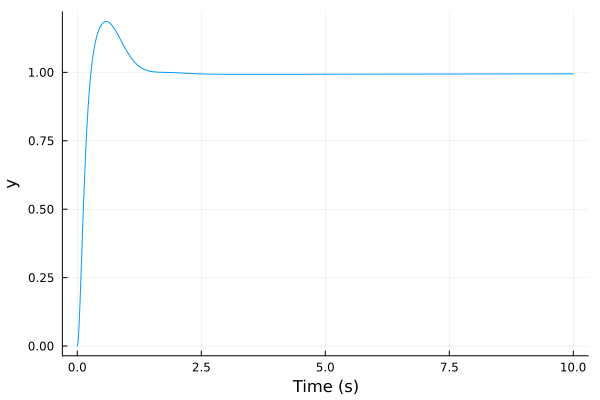

In [7]:
cl = feedback(e2q_c, 1)
@show zpk(cl)
@show poles(cl)
# bodeplot(cl)
step(cl, 10) |> plot

Now we have a SISO compensator design for q, let's use it to close the loop in the MIMO plant. The long_dyn MIMO system has two inputs, elevator input u_e and throttle input u_t. Our SISO compensator receives q_err as an input and outputs u_e. So the MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, must receive q_err and u_t as inputs and output u_e and u_t. Therefore, it must apply the SISO compensator to q_err to obtain u_e and let u_t pass through unchanged to the plant by applying an unit gain to it. This is achieved as follows:

In [8]:
#create a diagonal MIMO system from the pitch rate compensator and a unit
#transfer function
q_comp_MIMO = append(q_comp, tf(1)) |> ss #and convert to ss before concatenation

StateSpace{Continuous, Float64}
A = 
 0.0  4.0    0.0
 0.0  0.0    8.0
 0.0  0.0  -20.0
B = 
 0.0  0.0
 0.0  0.0
 4.0  0.0
C = 
 5.46875  3.59375  4.0
 0.0      0.0      0.0
D = 
 0.0  0.0
 0.0  1.0

Continuous-time state-space model

In [9]:
q_comp_long_dyn = series(q_comp_MIMO, long_dyn_ss) #equivalent to long_dyn_ss * q_comp_MIMO (in the product notation, the second system goes first)

StateSpace{Continuous, Float64}
A = 
 -0.2645904405504637     2.486992195889064      -9.738239462634965       -1.1271386879842566  -70.62142281045607    0.016378879126736922   -31.89284628605249   -20.958156130834492  -23.327338997798392
 -0.2320629144731776    -2.892436502843294      -0.8717969673217496      38.40353747785689     34.743313226339566   0.0003989943970161073   19.635036415739428   12.903023930343052   14.361626635512266
  1.571882697039128e-7   1.4072150026413449e-8   1.4230898490779373e-14   0.999998328579363     0.0                 0.0                      0.0                  0.0                  0.0
  0.33986255113338243   -4.049618214869186      -3.900794341288316e-6    -4.21869307456935    121.8147976017544     0.004363078259826451    50.68724866176805    33.30876340630472    37.07410187832178
 -0.11145971643636479    1.2450207738012182      0.0                      0.0                 -50.0                 0.0                      0.0                  0.0         

The setpoint vector to be applied to the closed-loop MIMO system is r = [q_cmd, u_t]. The input to the MIMO compensator must be e = [q_err, u_t] = r - f = [q_cmd, u_t] - [q, 0]. So we need a matrix gain that premultiplies the 7-component output vector of long_dyn, and produces a 2-component vector [q, 0]. This will be a 2x7 matrix with all entries set to zero except [1, 1] (the nonzero output goes in the first component, and q is the first element in long_dyn's output vector)

zpk(e2q_cl_MIMO) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                   (1.0s - 5.21771598138458e15)(1.0s + 49.66713043593127)(1.0s + 9.582550580643948)(1.0s^2 + 7.187499911273203s + 43.74999002107327)(1.0s + 1.623615495385918)(1.0s + 0.04911498060403002)(1.0s + 3.103897607416192e-5)
-2.842170943040401e-14----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                      (1.0s + 48.44782933754803)(1.0s^2 + 20.505452014100378s + 166.4999825301386)(1.0s + 9.583551835430384)(1.0s^2 + 6.072501968331833s + 28.878424220348343)(1.0s + 2.2656576523074854)(1.0s + 0.048681994037481226)(1.0s + 3.1038695747449226e-5)

Continuous-time transfer function model


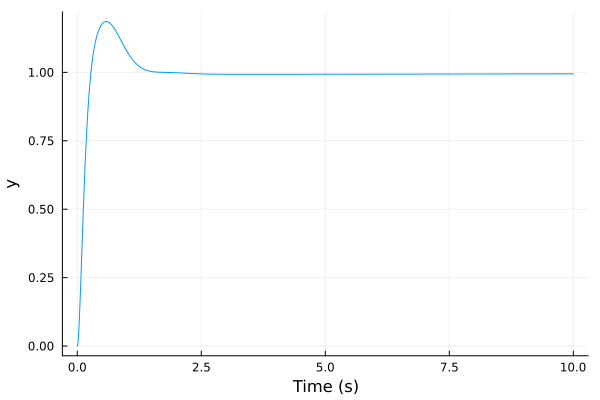

In [10]:
K_select = zeros(2, 7)
K_select[1,1] = 1
K_ss = ss(K_select) #creates a ss with no dynamics and K_select as feedthrough

#now create a feedback loop with K in the feedback path
q_comp_long_dyn_cl = feedback(q_comp_long_dyn, K_ss)

#this is similar, but NOT equivalent: it uses unit feedback, which means that
#the whole 7 component output vector from q_comp_long_dyn is fed back, and then
#multiplied by K_ss (and so reduced to 2 components) in the feedforward path
#before entering the compensator. this yields a 7 input closed loop system, of
#which only the two first inputs actually do anything (the others get discarded
# when they pass through K) q_comp_long_dyn_cl = feedback(series(K_ss,
# q_comp_long_dyn))

e2q_cl_MIMO = (q_comp_long_dyn_cl |> tf)[1,1]

#make sure the zpk data matches that of the SISO closed loop TF
@show zpk(e2q_cl_MIMO)

#check step response
step(e2q_cl_MIMO, 10) |> plot


zpk(e2q_c) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                          (1.0s + 49.66713035063847)(1.0s + 8.458409869212296)(1.0s + 2.4889585518404402)(1.0s + 1.6236140469522005)(1.0s + 0.049114731103773075)
880.509919610139--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                (1.0s + 49.999999999999226)(1.0s + 48.315816004399515)(1.0s^2 + 8.977671994276692s + 49.644235645519444)(1.0s + 4.99999999999999)(1.0s^2 + 0.04819984770640768s + 0.09426977979506858)(1.0s)

Continuous-time transfer function model
ss_err_step = e2q_c_err(0) = [0.0;;]


┌ Warning: High-order transfer functions are highly sensitive to numerical errors. The result may be inaccurate. Consider making use of statespace systems instead
└ @ ControlSystemsBase C:\Users\Miguel\.julia\packages\ControlSystemsBase\xwzuB\src\types\SisoTfTypes\SisoRational.jl:12


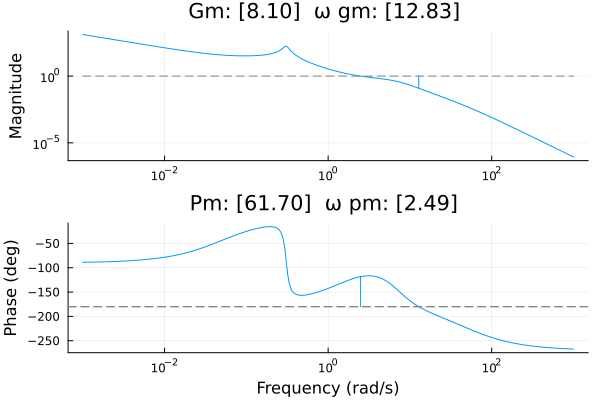

In [11]:
#let's see what we could achieve if we had an actuator in the loop with a 5Hz time constant
k_p = 4
k_i = 8
k_d = 0.3
τ_d = 0.02
q_comp = tf(1, [1, 0]) * (k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [τ_d, 1]))
act = tf(1, [0.2, 1])
    
e2q_c = q_comp * act * e2q
e2q_c = minreal(e2q_c, 1e-3)
@show zpk(e2q_c)
e2q_c_err = 1/(1+e2q_c)
#the steady state error for a given test input is the final value of the ETF for
#that input. applying the final value theorem, the final value for a step input
#is found simply by settng s=0. therefore:
@show ss_err_step = e2q_c_err(0)


marginplot(e2q_c)
# rlocusplot(e2q_c)
# nyquistplot(e2q_c)
# bodeplot(act)


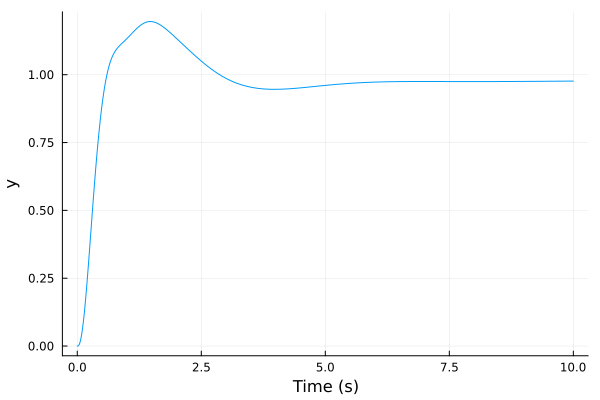

In [12]:
cl = feedback(e2q_c, 1)
step(cl, 10) |> plot

In [13]:
# world = SimpleWorld(Cessna172Rv0(LTF())) |> System; #for simulation, we use LTF kinematics

In [14]:
# #trim for the trim conditions above and simulate
# (success, result) = trim!(world; trim_params)
# @assert success
# sim = Simulation(world; t_end = 30, adaptive = true)
# Sim.run!(sim, verbose = true)
# # plots = make_plots(sim; Plotting.defaults...)
# plots = make_plots(TimeHistory(sim).ac.kinematics; Plotting.defaults...)
# save_plots(plots, save_folder = joinpath("tmp", "trim_sim_test"))